In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch.utils.data import DataLoader
import deepchem as dc

from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader 
from sklearn.model_selection import train_test_split

In [4]:
class GNNEncoder(nn.Module):
    def __init__(
        self, num_node_features=20, num_edge_features=11, hidden_dim=64, out_dim=64
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.proj_head = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_attr, batch_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h_pool = global_mean_pool(h, batch_index)
        z = self.proj_head(h_pool)
        return z

In [5]:
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_gnn, embed_dim=64, freeze_gnn=False):
        super().__init__()
        self.gnn = pretrained_gnn  

        if freeze_gnn:
            for param in self.gnn.parameters():
                param.requires_grad = False

        self.reg_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch_index):
        z = self.gnn(x, edge_index, edge_attr, batch_index)
        out = self.reg_head(z)
        return out.squeeze(-1)

In [7]:
pretrained_encoder = GNNEncoder(num_node_features=30, num_edge_features=11)
pretrained_encoder.load_state_dict(torch.load("pretrained_gnn.pt"))

fine_tune_model = FineTuneModel(pretrained_encoder, embed_dim=64, freeze_gnn=True)

/tmp/ipykernel_17898/1169483440.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_encoder.load_state_dict(torch.load("pretrained_gnn.pt"))


In [8]:
class MolGraphWithLogSDataset(Dataset):
    def __init__(self, smiles_list, logS_list, transform=None):
        super().__init__()
        self.smiles_list = smiles_list
        self.logS_list = logS_list
        self.featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        self.transform = transform

        assert len(self.smiles_list) == len(self.logS_list), \
            "SMILESのリストとlogSのリストの長さが合っていません。"

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smi = self.smiles_list[idx]
        mol = Chem.MolFromSmiles(smi)
        mol = AllChem.AddHs(mol)

        dgraph = self.featurizer.featurize([mol])[0]
        pyg_data = self._dc_to_pyg(dgraph)

        logS_value = self.logS_list[idx]
        pyg_data.y = torch.tensor([logS_value], dtype=torch.float)

        if self.transform is not None:
            pyg_data = self.transform(pyg_data)

        return pyg_data

    def _dc_to_pyg(self, dgraph):
        node_feats = torch.tensor(dgraph.node_features, dtype=torch.float)
        edge_index = torch.tensor(dgraph.edge_index, dtype=torch.long)
        edge_feats = torch.tensor(dgraph.edge_features, dtype=torch.float)

        data = Data(x=node_feats, edge_index=edge_index, edge_attr=edge_feats)
        return data


In [10]:
def create_dataloaders(train_dataset, valid_dataset, batch_size=32):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader

In [11]:
def train_regression(model, train_loader, valid_loader, epochs=20, lr=1e-3, device="cpu"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        ####################
        #      train
        ####################
        model.train()
        total_loss = 0.0
        for batch_data in train_loader:
            # batch_data は PyG の Batch
            batch_data = batch_data.to(device)
            pred = model(
                batch_data.x,
                batch_data.edge_index,
                batch_data.edge_attr,
                batch_data.batch
            )
            loss = criterion(pred, batch_data.y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_data.num_graphs

        train_loss = total_loss / len(train_loader.dataset)

        ####################
        #   validation
        ####################
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in valid_loader:
                batch_data = batch_data.to(device)
                pred = model(
                    batch_data.x,
                    batch_data.edge_index,
                    batch_data.edge_attr,
                    batch_data.batch
                )
                loss = criterion(pred, batch_data.y)
                val_loss += loss.item() * batch_data.num_graphs

        val_loss /= len(valid_loader.dataset)

        print(f"Epoch [{epoch}/{epochs}] | "
              f"Train MSE: {train_loss:.4f} | "
              f"Val MSE: {val_loss:.4f}")

    print("Fine-tuning (Regression) completed.")

In [20]:
df = pd.read_csv("../data/delaney-rdkitfp.csv")
smiles_list = df["smiles"].tolist()
logS_list = df["logS"].tolist()

train_smiles, test_smiles, train_logs, test_logs = train_test_split(
    smiles_list, logS_list,
    test_size=0.2, 
    random_state=42
)

train_smiles, val_smiles, train_logs, val_logs = train_test_split(
    train_smiles, train_logs,
    test_size=0.2,
    random_state=42
)
train_dataset = MolGraphWithLogSDataset(train_smiles, train_logs)
val_dataset = MolGraphWithLogSDataset(val_smiles, val_logs)
test_dataset = MolGraphWithLogSDataset(test_smiles, test_logs)

In [21]:
def create_dataloaders(train_dataset, valid_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader

train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
train_loader, valid_loader = create_dataloaders(
    train_dataset=train_dataset, 
    valid_dataset=val_dataset, 
    batch_size=32
)

In [24]:
train_regression(
    fine_tune_model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    epochs=20, 
    lr=1e-3, 
    device="cpu"
)

Epoch [1/20] | Train MSE: 14.0772 | Val MSE: 12.7638
Epoch [2/20] | Train MSE: 13.0768 | Val MSE: 11.6949
Epoch [3/20] | Train MSE: 11.8497 | Val MSE: 10.3428
Epoch [4/20] | Train MSE: 10.3530 | Val MSE: 8.6889
Epoch [5/20] | Train MSE: 8.6148 | Val MSE: 7.0001
Epoch [6/20] | Train MSE: 6.9397 | Val MSE: 5.5084
Epoch [7/20] | Train MSE: 5.5861 | Val MSE: 4.4619
Epoch [8/20] | Train MSE: 4.7353 | Val MSE: 3.8862
Epoch [9/20] | Train MSE: 4.3025 | Val MSE: 3.6455
Epoch [10/20] | Train MSE: 4.1242 | Val MSE: 3.5543
Epoch [11/20] | Train MSE: 4.0464 | Val MSE: 3.5052
Epoch [12/20] | Train MSE: 4.0048 | Val MSE: 3.4631
Epoch [13/20] | Train MSE: 3.9589 | Val MSE: 3.4095
Epoch [14/20] | Train MSE: 3.9176 | Val MSE: 3.3725
Epoch [15/20] | Train MSE: 3.8844 | Val MSE: 3.3341
Epoch [16/20] | Train MSE: 3.8458 | Val MSE: 3.3045
Epoch [17/20] | Train MSE: 3.8091 | Val MSE: 3.2663
Epoch [18/20] | Train MSE: 3.7701 | Val MSE: 3.2231
Epoch [19/20] | Train MSE: 3.7380 | Val MSE: 3.1924
Epoch [20/20] 

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def parity_plot(model, data_loader, ax, device="cpu", title="Parity Plot"):
    model.eval()
    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for batch_data in data_loader:
            batch_data = batch_data.to(device)
            pred = model(
                batch_data.x,
                batch_data.edge_index,
                batch_data.edge_attr,
                batch_data.batch
            ) 
            
            y_cpu = batch_data.y.detach().cpu().numpy().flatten()
            pred_cpu = pred.detach().cpu().numpy().flatten()

            true_vals.extend(y_cpu)
            pred_vals.extend(pred_cpu)

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)

    ax.scatter(true_vals, pred_vals, alpha=0.5, s=5)
    ax.set_title(title)
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
    ax.grid(True)
    ax.label_outer()

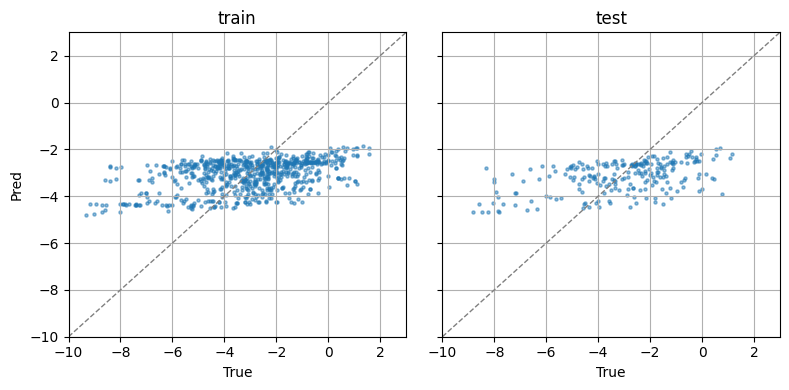

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
loaders = {
    "train": train_loader,
    "test": test_loader,
}
for i, (name, loader) in enumerate(loaders.items()):
    parity_plot(
        fine_tune_model, 
        loader, 
        ax=ax[i], 
        device="cpu", 
        title=name
    )
    ax[i].plot([-10, 3], [-10, 3], color="gray", linestyle="--", linewidth=1)
    ax[i].set_xlim(-10, 3)
    ax[i].set_ylim(-10, 3)
fig.tight_layout()
